In [1]:
import numpy as np
import pickle
import tensorflow as tf
import os
from matplotlib import pyplot as plt
from easydict import EasyDict as edict
import yaml
import cv2
from keras import backend as K

from scipy.linalg import sqrtm
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input

import cv2

Using TensorFlow backend.


### Function for using InceptionV3 keras model

In [0]:
# This code is adopted from 
# https://machinelearningmastery.com/how-to-implement-the-inception-score-from-scratch-for-evaluating-generated-images/
def scale_images(images, new_shape):
    scaled = []
    for i in range(len(images)):
        image = images[i,]
#         print(image.shape)
        new_image = cv2.resize(image, new_shape, interpolation = cv2.INTER_NEAREST)
        # store
        scaled.append(new_image)
    return np.array(scaled)
 
def calculate_fid(model, sample1, sample2, input_dim):
    sample1 = scale_images(sample1, (input_dim,input_dim))
    sample2 = scale_images(sample2, (input_dim,input_dim))
    print('Scaled', sample1.shape, sample2.shape)
    # pre-process images
    sample1 = preprocess_input(sample1)
    sample2 = preprocess_input(sample2)
    # calculate activations
    act1 = model.predict(sample1)
    act2 = model.predict(sample2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
#     print(np.max(sigma1 + sigma2 - 2.0 * covmean), np.min(sigma1 + sigma2 - 2.0 * covmean))
#     print(ssdiff, np.trace(sigma1 + sigma2 - 2.0 * covmean))
    return fid



### GAN implementation class

- DCGAN and SAGAN are blended together
- One can choose different functionalities, such as adding attention, conditional GAN, loss function by setting control bits

In [16]:
class cgan():
    def __init__(self):
        
        self._config = {}
        self._config["lrelu_alpha"] = 0.2
        self._config["d_lr"] = 4e-4
        self._config["g_lr"] = 2e-4
        self._config["beta1"] = 0.6
        self._config["epoch"] = 100
        self._config["noise_dim"] = 100
        self._config["label_dim"] = 10
        self._config["image_dim"] = [32, 32, 3]
        self._config["n_image"] = 5
        self._config["batch_size"] = 128
        self._config["save_rate"] = 500
        self._config["model_dir"] = "/content/drive/My Drive/sagan/model"
        self._config["image_dir"] = "/content/drive/My Drive/sagan/image"
        self._config["binary_dir"] = "/content/drive/My Drive/sagan/binary"
        
        self._history = {}
        
    def hw_flatten(self, x):
        """
        Help function for attention layer
        """
        return tf.reshape(x, shape=[-1, int(x.shape[1]*x.shape[2]), int(x.shape[-1])])
    
    def to_onehot(self, y):
        
        res = np.zeros([y.shape[0], self._config["label_dim"]])
        for i in range(len(y)):
            res[i][int(y[i])] = 1
            
        return res
    
    def attention_layer(self, x, is_training=True, reuse=None):
        with tf.variable_scope("attention", reuse=reuse):

            chan = x.shape[-1]
            # f=[bs, h, w, C/8], g=[bs, h, w, C/8], h=[bs, h, w, C]
            f = tf.layers.conv2d(x, filters=chan//8, kernel_size=(1, 1), strides=(1, 1), padding='same', name="f_att")
            g = tf.layers.conv2d(x, filters=chan//8, kernel_size=(1, 1), strides=(1, 1), padding='same', name="g_att")
            h = tf.layers.conv2d(x, filters=chan, kernel_size=(1, 1), strides=(1, 1), padding='same', name="h_att")
            
            # hw_flatten(f)=[bs, h*w, C/8], hw_flatten(h)=[bs, h*w, C]
            s = tf.matmul(self.hw_flatten(g), self.hw_flatten(f), transpose_b=True)

            att_map = tf.nn.softmax(s, axis=-1, name="att_map")  # attention map=[bs, h*w, h*w, C/8]

            o = tf.matmul(att_map, self.hw_flatten(h))  # [bs, h*w, C]
            gamma = tf.get_variable("gamma_att", [1], initializer=tf.constant_initializer(0.0))
#             print(self.hw_flatten(h).shape)
#             print(f.shape, g.shape, h.shape, s.shape, att_map.shape, o.shape)
            o = tf.reshape(o, shape=[-1, x.shape[1], x.shape[2], x.shape[3]])  # [bs, h, w, C]
            x = gamma * o + x

        return x
    
    def generator(self, noise, label, reuse=None, training=True, attention=False, condition=False):
        """
        Build generator
        """
        kernelinit = tf.contrib.layers.xavier_initializer()
        with tf.variable_scope("generator", reuse=reuse):     
            if condition:
                x = tf.concat([noise, label], axis=1)
            else:
                x = noise
            
            x = tf.layers.dense(x, 2048)
            x = tf.reshape(x, shape=[-1, 4, 4, 128])
            x = tf.contrib.layers.batch_norm(x, is_training=training)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])
            
            
            
            x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(5, 5), strides=(2, 2),padding='same', 
                                           kernel_initializer=kernelinit)
            x = tf.contrib.layers.batch_norm(x, is_training=training)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])
            
            if attention:
                x = self.attention_layer(x, is_training=training, reuse=reuse)
            
            x = tf.layers.conv2d_transpose(x, filters=32, kernel_size=(5, 5), strides=(2, 2),padding='same',
                                          kernel_initializer=kernelinit)
            x = tf.contrib.layers.batch_norm(x, is_training=training)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])            
            
            x = tf.layers.conv2d_transpose(x, filters=3, kernel_size=(5, 5), strides=(2, 2),padding='same',
                                          kernel_initializer=kernelinit)

            x = tf.tanh(x)
    
            
        return x
    
    def discriminator(self, img, label, reuse=None, training=True, attention=False, condition=False):
        """
        Build discriminator
        """
        kernelinit = tf.contrib.layers.xavier_initializer()
        with tf.variable_scope("discriminator", reuse=reuse):            
            # Concat real image and label to one input tensor
            if condition:
                a, b, c = self._config["image_dim"]
                y = tf.layers.dense(label, a*b*1)
                y = tf.reshape(y, shape=[-1, a, b, 1])
                x = tf.concat([img, y], axis=3)
#                 x = tf.concat([img, y*tf.ones(shape=[1, img.shape[1], img.shape[2], y.shape[3]])], axis=3)
            else:
                x = img
            
            x = tf.layers.conv2d(x, filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                kernel_initializer=kernelinit)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])
            
            x = tf.layers.conv2d(x, filters=32, kernel_size=(5, 5), strides=(2, 2), padding='same',
                                kernel_initializer=kernelinit)
            x = tf.contrib.layers.batch_norm(x, is_training=training)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])
            
            x = tf.layers.conv2d(x, filters=64, kernel_size=(5, 5), strides=(2, 2),padding='same',
                                kernel_initializer=kernelinit)
            x = tf.contrib.layers.batch_norm(x, is_training=training)
            x = tf.nn.leaky_relu(x, alpha=self._config["lrelu_alpha"])
            
            if attention:
                x = self.attention_layer(x, is_training=training, reuse=reuse)
            
            x = tf.layers.flatten(x)
            x_logits = tf.layers.dense(x, 1) # no sigmoid activation
            x = tf.nn.sigmoid(x_logits)
        
        return x, x_logits
    
    
    
    def sample_image(self, itr, sess, noise, gen_out, label, is_training): 
        """
        For sampling image during training
        """
        
        r, c = self._config["n_image"], self._config["n_image"]
        
        def temp_seed(seed):
            state = np.random.get_state()
            np.random.seed(seed)
            noi = np.random.normal(0, 1, (r * c, self._config["noise_dim"]))
            lab = np.random.randint(self._config["label_dim"], size=[r * c, 1]) # random label
            np.random.set_state(state)
            return noi, lab
        
#         noi, _ = temp_seed(1)
        
        lab = np.array([i%self._config["label_dim"] for i in range(r*c)]).reshape(r*c, 1)   # specific label        
        lab = self.to_onehot(lab)
        
        gen_imgs = sess.run(gen_out, feed_dict={noise:noi, label: lab, is_training: False}) # -1~1
        gen_imgs = gen_imgs*0.5 + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        prefix="B{}".format(itr)
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(self._config["image_dir"]+"/"+prefix+".png")
        plt.close()
        
    def generate_image(self, r, c, sess, noise, gen_out, label, is_training): 
        """
        Generate images during inference
        """
                
        noi = np.random.normal(0, 1, (r * c, self._config["noise_dim"]))
        
        lab = np.random.randint(self._config["label_dim"], size=[r * c, 1]) # random label
        
        lab = np.array([i%self._config["label_dim"] for i in range(r*c)]).reshape(r*c, 1)   # specific label        
        lab = self.to_onehot(lab)
        
        gen_imgs = sess.run(gen_out, feed_dict={noise:noi, label: lab, is_training: False}) # -1~1
        gen_imgs = gen_imgs*0.5 + 0.5
        
        fig, axs = plt.subplots(r, c)
        cnt = 0
        
        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(gen_imgs[cnt, :,:,:])
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
    
    def save_hist(self, path):
        with open(path, "wb") as writer:
            print(path)
            pickle.dump(self._history, writer)
            
    
    def train(self, x_train, y_train, x_test, incept_model, incept_dim, attention=True, condition=True, hindge_loss=False, 
              fid=True, model_path=None):
        
        np.random.seed(2)
        global graph_k # Inception V3 graph for keras session, different from tf session
        tf.reset_default_graph()
        # Set up placeholder
        noise = tf.placeholder(dtype=tf.float32, shape=[None, self._config["noise_dim"]], name="noise")
        label = tf.placeholder(dtype=tf.float32, shape=[None, self._config["label_dim"]], name="label") # one-hot value
        is_training = tf.placeholder(dtype=tf.bool, name="is_training")        
        real_img = tf.placeholder(dtype=tf.float32, 
                             shape=[None]+self._config["image_dim"],
                            name="image")
        # Calculate fake image tensor, the discriminator logits for real and fake images
        fake_img = self.generator(noise, label, reuse=None, training=is_training, attention=attention, condition=condition)
#         print(fake_img.shape)
        real_label, real_logits = self.discriminator(real_img, label, reuse=False, training=is_training, 
                                                     attention=attention, condition=condition)
        fake_label, fake_logits = self.discriminator(fake_img, label, reuse=True, training=is_training, 
                                                     attention=attention, condition=condition)
        
        # Select loss type and calculate loss
        if hindge_loss:
            d_loss_real = tf.reduce_mean(tf.nn.relu( 1.0 - real_logits), name="d_loss_real")
            d_loss_fake = tf.reduce_mean(tf.nn.relu( 1.0 + fake_logits), name="d_loss_fake")
            d_loss = d_loss_real + d_loss_fake
            g_loss = tf.reduce_mean( - fake_logits, name="g_loss")
            
        else:
            
            d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, 
                                                                                 labels=tf.ones_like(real_logits)), 
                                         name="d_loss_real")

            d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                                 labels=tf.zeros_like(fake_logits)), 
                                         name="d_loss_fake")
            
            g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, 
                                                                             labels=tf.ones_like(fake_logits)), 
                                     name="g_loss")
    
            d_loss = tf.add(d_loss_real/2, d_loss_fake/2, name="d_loss") # same dimention for real and fake data
        
        # Optimizer setup
        var_g = [var for var in tf.trainable_variables() if var.name.startswith("generator")]
        var_d = [var for var in tf.trainable_variables() if var.name.startswith("discriminator")]
        
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        gen_updates = [op for op in update_ops if op.name.startswith('generator')]
        with tf.control_dependencies(update_ops): # for training batchnormalization
            op_d = tf.train.AdamOptimizer(learning_rate=self._config["d_lr"], beta1=self._config["beta1"]
                                         ).minimize(d_loss, var_list=var_d)
            op_g = tf.train.AdamOptimizer(learning_rate=self._config["g_lr"], beta1=self._config["beta1"]
                                         ).minimize(g_loss, var_list=var_g)
        sess = tf.Session()
        saver=tf.train.Saver()
        # Inference process. Restore model, generate images and return
        if model_path is not None: 
            saver.restore(sess, model_path)
            print("Model restored.")
            self.generate_image(5, 5, sess, noise, fake_img, label, is_training)
            
            return
        
        # Training process
        sess.run(tf.global_variables_initializer())
        
#         with graph_k.as_default():
#             print(K.get_session()) # confirm keras session does not change
        
        # Prep data
        epoch = self._config["epoch"]
        batch_size = self._config["batch_size"]
        data_idx = np.arange(0, len(x_train))
        np.random.shuffle(data_idx)
        print("Data size is: ", data_idx.shape)
        print("Total epoch, batch size: ", epoch, batch_size)
        
        counter_global = 0
        
        for i in range(epoch):
            
            if len(x_train)%batch_size==0:
                itr = int(len(x_train)/batch_size)
            else:
                itr = int(len(x_train)/batch_size) + 1
            
            for j in range(itr):
                idx = data_idx[j*batch_size : (j+1)*batch_size]
                img = x_train[idx,:,:,:].astype(np.float32)
                lab = self.to_onehot(y_train[idx,].astype(np.float32))
                
                noi = np.random.normal(0.0, 1.0, [len(img), self._config["noise_dim"]]).astype(np.float32)
                
                # Obtain current loss and accuracy
                d_loss_r, d_loss_fake_r, d_loss_real_r, g_loss_r, real_label_r, fake_label_r = \
                          sess.run([d_loss, d_loss_fake, d_loss_real, g_loss, real_label, fake_label], 
                                   feed_dict={noise: noi, real_img: img, label: lab, is_training: False})
                
#                 print(real_label_r)
                real_count = np.where(real_label_r>0.5)[0].shape[0]
                fake_count = np.where(fake_label_r<0.5)[0].shape[0]
                acc_real = real_count/len(real_label_r)
                acc_fake = fake_count/len(fake_label_r)
                acc_d = (real_count+fake_count)/(len(real_label_r)+len(fake_label_r))
                
                
                train_d = True
                train_g = True
                
                if len(self._history)==0:
                    self._history["d_loss"] = [d_loss_r]
                    self._history["g_loss"] = [g_loss_r]
                    self._history["d_loss_fake"] = [d_loss_fake_r]
                    self._history["d_loss_real"] = [d_loss_real_r]
                    self._history["train_d"] = [train_d]
                    self._history["train_g"] = [train_g]
                    self._history["acc_real"] = [acc_real]
                    self._history["acc_fake"] = [acc_fake]
                    self._history["acc_d"] = [acc_d]
                else:
                    self._history["d_loss"].append(d_loss_r)
                    self._history["g_loss"].append(g_loss_r)
                    self._history["d_loss_fake"].append(d_loss_fake_r)
                    self._history["d_loss_real"].append(d_loss_real_r)
                    self._history["train_d"].append(train_d)
                    self._history["train_g"].append(train_g)
                    self._history["acc_real"].append(acc_real)
                    self._history["acc_fake"].append(acc_fake)
                    self._history["acc_d"].append(acc_d)
                
                # Update gradients
                if train_d:
                    sess.run(op_d, feed_dict={noise: noi, real_img: img, label: lab, is_training: True})
                    
                if train_g:
                    sess.run(op_g, feed_dict={noise: noi, real_img: img, label: lab, is_training: True})
                
                # Print current loss and accuracy
                if counter_global%10 == 0:
                    print("Epoch %d, iter %d, d: %.4f, acc_f: %.4f, acc_r: %.4f, acc: %.4f, g: %.4f, tr_d: %d, tr_g: %d" %
                              (i, j, d_loss_r, acc_fake, acc_real, acc_d, g_loss_r, train_d, train_g))
                # Save history dictionary
                if counter_global%self._config["save_rate"] == 0:
                    print("Save model, history...")
                    surfix = "_dlr"+str(self._config["d_lr"])+ \
                                    "_glr"+str(self._config["g_lr"])
                    saver.save(sess, self._config["model_dir"]+"/train"+surfix+".pkl")
                    self.sample_image(counter_global, sess, noise, fake_img, label, is_training)
                    self.save_hist(self._config["binary_dir"]+"/hist"+surfix+".pkl")
                # Calculate FID    
                if fid and counter_global % 1000 == 0:

                    index = np.arange(len(x_test))
                    rimg = x_test[index[:1000], ]*127.5 + 127.5
                    noi = np.random.normal(0, 1, (1000, self._config["noise_dim"]))
                    fimg = sess.run(fake_img, feed_dict={noise:noi, label: lab, is_training: False}) # -1~1
                    fimg = fimg*127.5 + 127.5
                    
                    with graph_k.as_default():
                        fid_score = calculate_fid(incept_model, rimg, fimg, incept_dim)
                        print("fid score: ", fid_score)
                    if "fid" not in self._history:
                        self._history["fid"] = [fid_score]
                        self._history["fid_iter"] = [counter_global]
                    else:
                        self._history["fid"].append(fid_score)
                        self._history["fid_iter"].append(counter_global)
                        
                    
                    
                counter_global += 1
            
            

### Import data

In [9]:
[x_train, y_train], (x_test, _) = tf.keras.datasets.cifar10.load_data()
x_train = x_train/127.5 - 1.0 # scale pixel value to [-1, 1]
x_test = x_test/127.5 - 1.0

170500096/170498071 [==============================] - 123s 1us/step


### Employ InceptionV3 Model

In [0]:
tf.reset_default_graph()
K.clear_session()

incept_dim = 299
incept_model = InceptionV3(include_top=False, pooling='avg', input_shape=(incept_dim,incept_dim,3))
# print(incept_model.predict(np.ones([2,299,299,3])))
graph_k = tf.get_default_graph()


[[0.00409026 0.02435097 0.01881441 ... 0.77942955 0.03149062 0.02660897]
 [0.00409025 0.02435083 0.01881436 ... 0.7794293  0.03149068 0.02660891]]


### Create GAN class instance

In [130]:
mygan = cgan()
mygan._config

{'batch_size': 128,
 'beta1': 0.6,
 'binary_dir': '/content/drive/My Drive/sagan/binary',
 'd_lr': 0.0004,
 'epoch': 100,
 'g_lr': 0.0002,
 'image_dim': [32, 32, 3],
 'image_dir': '/content/drive/My Drive/sagan/image',
 'label_dim': 10,
 'lrelu_alpha': 0.2,
 'model_dir': '/content/drive/My Drive/sagan/model',
 'n_image': 5,
 'noise_dim': 100,
 'save_rate': 500}

### Train process

In [122]:
# attention : add attentional layer
# condition : switch to conditional gan
# fid : compute FID during training
mygan.train(x_train, y_train, x_test, incept_model, incept_dim, attention=True, condition=False, fid=False, 
            hindge_loss=True)

Data size is:  (50000,)
Total epoch, batch size:  100 128
Epoch 0, iter 0, d: 1.9476, acc_f: 0.0625, acc_r: 0.9141, acc: 0.4883, g: -0.0024, tr_d: 1, tr_g: 1
Save model, history...
/content/drive/My Drive/sagan/binary/hist_dlr0.0004_glr0.0002.pkl
Epoch 0, iter 10, d: 2.0169, acc_f: 1.0000, acc_r: 0.2891, acc: 0.6445, g: 0.0159, tr_d: 1, tr_g: 1
Epoch 0, iter 20, d: 2.0648, acc_f: 1.0000, acc_r: 0.0938, acc: 0.5469, g: 0.0268, tr_d: 1, tr_g: 1
Epoch 0, iter 30, d: 2.1853, acc_f: 1.0000, acc_r: 0.0078, acc: 0.5039, g: 0.0309, tr_d: 1, tr_g: 1
Epoch 0, iter 40, d: 2.2012, acc_f: 0.9609, acc_r: 0.0547, acc: 0.5078, g: 0.0058, tr_d: 1, tr_g: 1
Epoch 0, iter 50, d: 2.3419, acc_f: 0.8828, acc_r: 0.0000, acc: 0.4414, g: 0.0045, tr_d: 1, tr_g: 1
Epoch 0, iter 60, d: 2.2848, acc_f: 0.3672, acc_r: 0.0000, acc: 0.1836, g: -0.0010, tr_d: 1, tr_g: 1
Epoch 0, iter 70, d: 2.3092, acc_f: 1.0000, acc_r: 0.0000, acc: 0.5000, g: 0.0257, tr_d: 1, tr_g: 1
Epoch 0, iter 80, d: 2.1961, acc_f: 0.9766, acc_r: 0

## Evaluate

### Plot function

In [20]:
def plot_results(restore_path):
    with open(restore_path+"binary/hist_dlr0.0004_glr0.0002.pkl", "rb") as f:
        hist = pickle.load(f)

#     print(hist.keys())

    index = np.arange(0, len(hist["d_loss"]), 100)
    plt.figure(1)
    plt.plot(index, np.array(hist["d_loss"])[index], color="b", linewidth=2)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("D loss", fontsize=12)
    
    plt.figure(2)
    plt.plot(index, np.array(hist["g_loss"])[index], color="b", linewidth=2)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("G loss", fontsize=12)
    
    plt.figure(3)
    plt.plot(index, np.array(hist["acc_d"])[index], color="b", linewidth=2)
    plt.xlabel("Iteration", fontsize=12)
    plt.ylabel("D accuracy", fontsize=12)
    
    plt.figure(4)
    plt.plot(np.array(hist["fid_iter"]), np.array(hist["fid"]), color="b", linewidth=2)
    plt.xlabel("FID iteration", fontsize=12)
    plt.ylabel("FID", fontsize=12)

### Results of DCGAN model

INFO:tensorflow:Restoring parameters from /Users/huo/Pythonpractice/DL/colabresult/result4_dcgan_bigmodel/model/train_dlr0.0004_glr0.0002.pkl
Model restored.


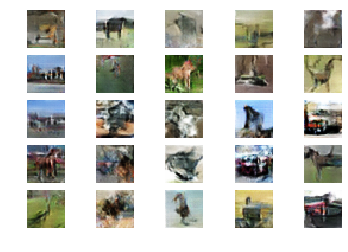

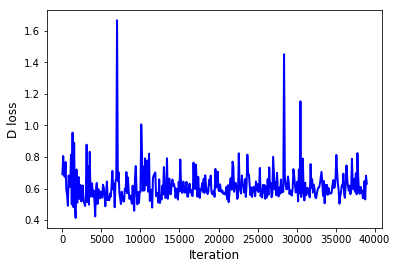

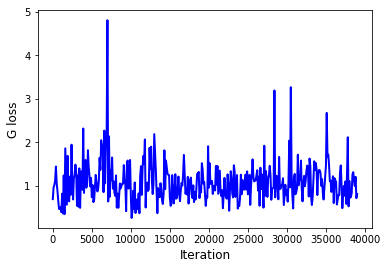

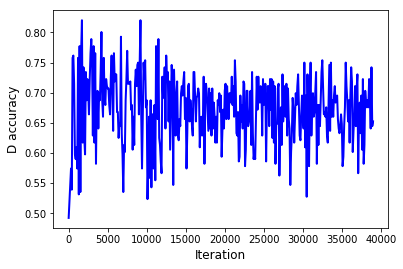

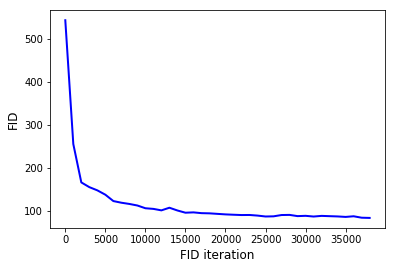

In [21]:
restore_path = "/Users/huo/Pythonpractice/DL/colabresult/result4_dcgan_bigmodel/"

mygan_infer = cgan()
mygan_infer.train(x_train, y_train, x_test, None, None, attention=False, condition=False, fid=False, \
            hindge_loss=True, model_path=restore_path+"model/train_dlr0.0004_glr0.0002.pkl")

plot_results(restore_path)

### Results of DCGAN with attention and hindge loss

INFO:tensorflow:Restoring parameters from /Users/huo/Pythonpractice/DL/colabresult/result5_attetion_bigmodel/model/train_dlr0.0004_glr0.0002.pkl
Model restored.


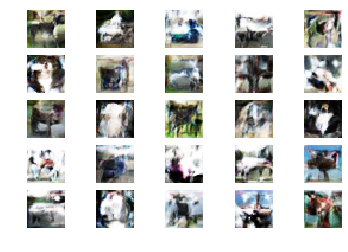

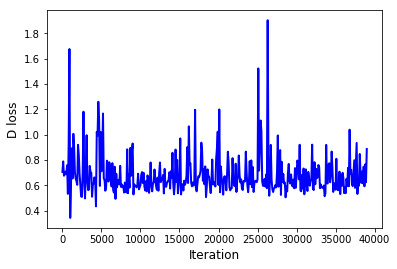

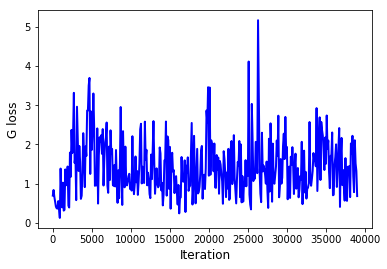

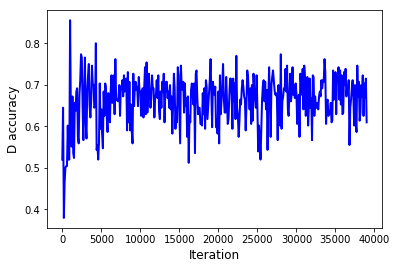

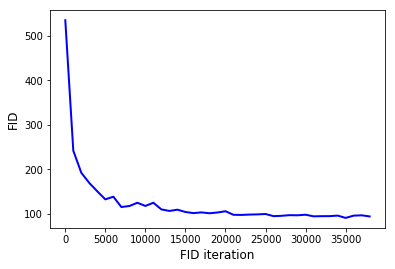

In [23]:
restore_path = "/Users/huo/Pythonpractice/DL/colabresult/result5_attetion_bigmodel/"

mygan_infer = cgan()
mygan_infer.train(x_train, y_train, x_test, None, None, attention=False, condition=False, fid=False, \
            hindge_loss=True, model_path=restore_path+"model/train_dlr0.0004_glr0.0002.pkl")

plot_results(restore_path)

### Comparison

In [24]:
restore_path = "/Users/huo/Pythonpractice/DL/colabresult/result4_dcgan_bigmodel/"

with open(restore_path+"binary/hist_dlr0.0004_glr0.0002.pkl", "rb") as f:
    hist_dcgan = pickle.load(f)

restore_path = "/Users/huo/Pythonpractice/DL/colabresult/result5_attetion_bigmodel/"
with open(restore_path+"binary/hist_dlr0.0004_glr0.0002.pkl", "rb") as f:
    hist_sagan = pickle.load(f)
#     print(hist.keys())

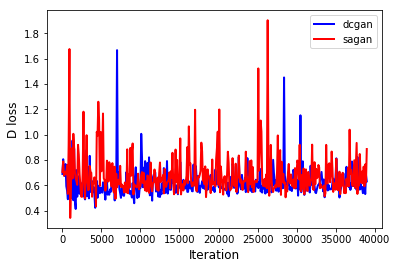

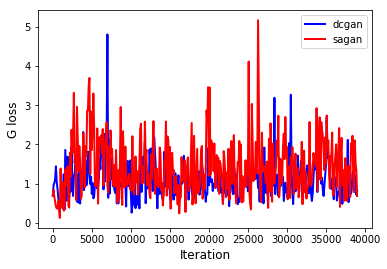

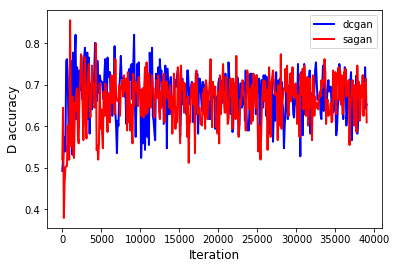

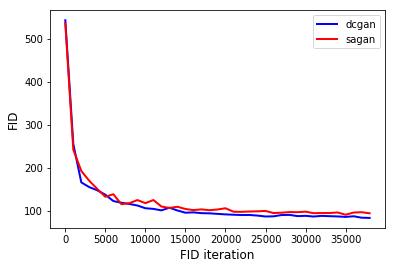

In [32]:
index = np.arange(0, len(hist_dcgan["d_loss"]), 100)

plt.figure(1)
plt.plot(index, np.array(hist_dcgan["d_loss"])[index], color="b", linewidth=2, label="dcgan")
plt.plot(index, np.array(hist_sagan["d_loss"])[index], color="r", linewidth=2, label="sagan")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("D loss", fontsize=12)
plt.legend()
plt.show()

plt.figure(2)
plt.plot(index, np.array(hist_dcgan["g_loss"])[index], color="b", linewidth=2, label="dcgan")
plt.plot(index, np.array(hist_sagan["g_loss"])[index], color="r", linewidth=2, label="sagan")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("G loss", fontsize=12)
plt.legend()
plt.show()

plt.figure(3)
plt.plot(index, np.array(hist_dcgan["acc_d"])[index], color="b", linewidth=2, label="dcgan")
plt.plot(index, np.array(hist_sagan["acc_d"])[index], color="r", linewidth=2, label="sagan")
plt.xlabel("Iteration", fontsize=12)
plt.ylabel("D accuracy", fontsize=12)
plt.legend()
plt.show()

plt.figure(4)
plt.plot(np.array(hist_dcgan["fid_iter"]), np.array(hist_dcgan["fid"]), color="b", linewidth=2, label="dcgan")
plt.plot(np.array(hist_sagan["fid_iter"]), np.array(hist_sagan["fid"]), color="r", linewidth=2, label="sagan")
plt.xlabel("FID iteration", fontsize=12)
plt.ylabel("FID", fontsize=12)
plt.legend()
plt.show()